In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import time
import math

Question 3

In [27]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class ConvEquivariantLayer(layers.Layer):
    def __init__(self, output_dim, activation=None):
        super(ConvEquivariantLayer, self).__init__()
        self.output_dim = output_dim
        self.activation = activation
        
    def build(self, input_shape):
        # For an equivariant layer using 1D convolutions
        # We'll use two filters: one for point-wise operations and one for pooling
        
        self.point_conv = layers.Conv1D(
            filters=self.output_dim,
            kernel_size=1,
            use_bias=False
        )
        
        self.pool_conv = layers.Conv1D(
            filters=self.output_dim,
            kernel_size=1,
            use_bias=True
        )
        
    def call(self, inputs):
        # Apply point-wise convolution
        point_out = self.point_conv(inputs)
        
        # Pool across set elements and apply second convolution
        pool_input = tf.tile(
            tf.reduce_mean(inputs, axis=1, keepdims=True),
            [1, tf.shape(inputs)[1], 1]
        )
        pool_out = self.pool_conv(pool_input)
        
        # Combine outputs
        output = point_out + pool_out
        
        # Apply activation if specified
        if self.activation:
            output = self.activation(output)
            
        return output

def build_equivariant_model(m, d, L, w):
    """
    Build a feedforward equivariant neural network
    
    Parameters:
    - m: number of items in the set
    - d: dimensionality of each item
    - L: number of equivariant layers
    - w: width of hidden layers
    
    Returns:
    - model: TensorFlow/Keras model
    """
    inputs = layers.Input(shape=(m, d))
    
    # Use the ConvEquivariantLayer implementation
    EquivLayer = ConvEquivariantLayer
    
    # First L-1 layers with ReLU activation
    x = inputs
    for _ in range(L-1):
        x = EquivLayer(w, activation=tf.nn.relu)(x)
    
    # Final layer with no activation
    outputs = EquivLayer(1)(x)
    
    # Reshape to match expected output shape (m,)
    outputs = layers.Reshape((m,))(outputs)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model with Adam optimizer and MSE loss
    model.compile(
        optimizer=Adam(learning_rate=1e-4, epsilon=1e-3),
        loss='mse',
        metrics=['mse']
    )
    
    return model

# Function to load and preprocess data
def load_data(xtrain_path, ytrain_path, xtest_path, ytest_path, m=5, d=3):
    """
    Load and preprocess the data, dropping the first column (index) from each CSV
    
    Parameters:
    - xtrain_path: path to training input data
    - ytrain_path: path to training output data
    - xtest_path: path to test input data
    - ytest_path: path to test output data
    - m: number of items in the set
    - d: dimensionality of each item
    
    Returns:
    - X_train, y_train, X_test, y_test: preprocessed data
    """
    # Load data, dropping the first column (index)
    X_train = pd.read_csv(xtrain_path, header=None).iloc[:, 1:].values
    y_train = pd.read_csv(ytrain_path, header=None).iloc[:, 1:].values
    X_test = pd.read_csv(xtest_path, header=None).iloc[:, 1:].values
    y_test = pd.read_csv(ytest_path, header=None).iloc[:, 1:].values
    
    print(f"X_train shape before reshape: {X_train.shape}")
    print(f"X_test shape before reshape: {X_test.shape}")
    
    # Reshape X data from (samples, m*d) to (samples, m, d)
    X_train = X_train.reshape(X_train.shape[0], m, d)
    X_test = X_test.reshape(X_test.shape[0], m, d)
    
    print(f"X_train shape after reshape: {X_train.shape}")
    print(f"X_test shape after reshape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test

# Function to train model and evaluate
def train_and_evaluate(L, w, X_train, y_train, X_test, y_test):
    """
    Train a model with given parameters and evaluate on test data
    
    Parameters:
    - L: number of equivariant layers
    - w: width of hidden layers
    - X_train, y_train: training data
    - X_test, y_test: test data
    
    Returns:
    - model: trained model
    - history: training history
    - test_mse: test mean squared error
    """
    from tensorflow.keras.callbacks import EarlyStopping
    
    m, d = X_train.shape[1], X_train.shape[2]
    
    # Build model
    model = build_equivariant_model(m, d, L, w)
    
    # Add early stopping callback with both patience and min_delta
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=7,               # Changed from 5 to 7
        min_delta=0.001,          # Added minimum improvement threshold of 0.001
        verbose=1,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        batch_size=300,
        epochs=100,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    # Evaluate on test data
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    test_mse = test_loss[0]  # MSE is both the loss and a metric
    
    # Print additional information
    print(f"Training stopped after {len(history.history['loss'])} epochs")
    if len(history.history['loss']) < 100:
        print("Early stopping was triggered")
    
    return model, history, test_mse



Loading data...
X_train shape before reshape: (200001, 15)
X_test shape before reshape: (200001, 15)
X_train shape after reshape: (200001, 5, 3)
X_test shape after reshape: (200001, 5, 3)
y_train shape: (200001, 5)
y_test shape: (200001, 5)
Data loaded successfully. Training data shape: (200001, 5, 3), (200001, 5)
Test data shape: (200001, 5, 3), (200001, 5)

Training model with L=5, w=2


Epoch 1/100
600/600 [==============================] - 3s 3ms/step - loss: 0.1714 - mse: 0.1714 - val_loss: 0.1652 - val_mse: 0.1652
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1637 - mse: 0.1637 - val_loss: 0.1627 - val_mse: 0.1627
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1620 - mse: 0.1620 - val_loss: 0.1615 - val_mse: 0.1615
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.1609 - val_mse: 0.1609
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1607 - mse: 0.1607 - val_loss: 0.1605 - val_mse: 0.1605
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1605 - mse: 0.1605 - val_loss: 0.1604 - val_mse: 0.1604
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1603 - mse: 0.1603 - val_loss: 0.1602 - val_mse: 0.1602
Epoch 8/100
600/600 [==============================] - 1s 2ms/step - 

Training stopped after 13 epochs
Early stopping was triggered

Test MSE for L=5, w=2: 0.160376
Training completed in 21.91 seconds
Model has 49 trainable parameters

Training model with L=2, w=10
Epoch 1/100
600/600 [==============================] - 1s 2ms/step - loss: 1.4699 - mse: 1.4699 - val_loss: 0.9456 - val_mse: 0.9456
Epoch 2/100
600/600 [==============================] - 1s 1ms/step - loss: 0.6799 - mse: 0.6799 - val_loss: 0.4882 - val_mse: 0.4882
Epoch 3/100
600/600 [==============================] - 1s 1ms/step - loss: 0.3867 - mse: 0.3867 - val_loss: 0.3121 - val_mse: 0.3121
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2713 - mse: 0.2713 - val_loss: 0.2411 - val_mse: 0.2411
Epoch 5/100
600/600 [==============================] - 1s 1ms/step - loss: 0.2240 - mse: 0.2240 - val_loss: 0.2114 - val_mse: 0.2114
Epoch 6/100
600/600 [==============================] - 1s 1ms/step - loss: 0.2032 - mse: 0.2032 - val_loss: 0.1971 - val_mse: 0.1971
Epoch 

Training stopped after 64 epochs
Early stopping was triggered

Test MSE for L=2, w=10: 0.152155
Training completed in 70.44 seconds
Model has 91 trainable parameters

Training model with L=2, w=100
Epoch 1/100
600/600 [==============================] - 3s 4ms/step - loss: 0.1778 - mse: 0.1778 - val_loss: 0.1645 - val_mse: 0.1645
Epoch 2/100
600/600 [==============================] - 2s 4ms/step - loss: 0.1623 - mse: 0.1623 - val_loss: 0.1612 - val_mse: 0.1612
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1606 - mse: 0.1606 - val_loss: 0.1603 - val_mse: 0.1603
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1600 - mse: 0.1600 - val_loss: 0.1598 - val_mse: 0.1598
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1596 - mse: 0.1596 - val_loss: 0.1594 - val_mse: 0.1594
Epoch 6/100
600/600 [==============================] - 3s 4ms/step - loss: 0.1592 - mse: 0.1592 - val_loss: 0.1591 - val_mse: 0.1591
Epoc

Training stopped after 40 epochs
Early stopping was triggered

Test MSE for L=2, w=100: 0.152943
Training completed in 92.31 seconds
Model has 901 trainable parameters

Training model with L=2, w=200
Epoch 1/100
600/600 [==============================] - 3s 5ms/step - loss: 0.1665 - mse: 0.1665 - val_loss: 0.1608 - val_mse: 0.1608
Epoch 2/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1603 - mse: 0.1603 - val_loss: 0.1599 - val_mse: 0.1599
Epoch 3/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1596 - mse: 0.1596 - val_loss: 0.1594 - val_mse: 0.1594
Epoch 4/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1592 - mse: 0.1592 - val_loss: 0.1590 - val_mse: 0.1590
Epoch 5/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1588 - mse: 0.1588 - val_loss: 0.1586 - val_mse: 0.1586
Epoch 6/100
600/600 [==============================] - 4s 6ms/step - loss: 0.1584 - mse: 0.1584 - val_loss: 0.1582 - val_mse: 0.1582
Ep

Training stopped after 34 epochs
Early stopping was triggered

Test MSE for L=2, w=200: 0.152549
Training completed in 145.96 seconds
Model has 1,801 trainable parameters

Training model with L=3, w=5
Epoch 1/100
600/600 [==============================] - 2s 2ms/step - loss: 0.2679 - mse: 0.2679 - val_loss: 0.2175 - val_mse: 0.2175
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2048 - mse: 0.2048 - val_loss: 0.1947 - val_mse: 0.1947
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1887 - mse: 0.1887 - val_loss: 0.1830 - val_mse: 0.1830
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1795 - mse: 0.1795 - val_loss: 0.1759 - val_mse: 0.1759
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1736 - mse: 0.1736 - val_loss: 0.1712 - val_mse: 0.1712
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1696 - mse: 0.1696 - val_loss: 0.1679 - val_mse: 0.1679
E

Training stopped after 21 epochs
Early stopping was triggered

Test MSE for L=3, w=5: 0.160119
Training completed in 30.76 seconds
Model has 101 trainable parameters

Training model with L=3, w=10
Epoch 1/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2276 - mse: 0.2276 - val_loss: 0.1812 - val_mse: 0.1812
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1745 - mse: 0.1745 - val_loss: 0.1706 - val_mse: 0.1706
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1686 - mse: 0.1686 - val_loss: 0.1672 - val_mse: 0.1672
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1660 - mse: 0.1660 - val_loss: 0.1652 - val_mse: 0.1652
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1644 - mse: 0.1644 - val_loss: 0.1639 - val_mse: 0.1639
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1634 - mse: 0.1634 - val_loss: 0.1630 - val_mse: 0.1630
Epoch

Training stopped after 42 epochs
Early stopping was triggered

Test MSE for L=3, w=10: 0.150467
Training completed in 72.57 seconds
Model has 301 trainable parameters

Training model with L=3, w=100
Epoch 1/100
600/600 [==============================] - 8s 11ms/step - loss: 0.1828 - mse: 0.1828 - val_loss: 0.1622 - val_mse: 0.1622
Epoch 2/100
600/600 [==============================] - 5s 8ms/step - loss: 0.1613 - mse: 0.1613 - val_loss: 0.1607 - val_mse: 0.1607
Epoch 3/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1602 - mse: 0.1602 - val_loss: 0.1598 - val_mse: 0.1598
Epoch 4/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1594 - mse: 0.1594 - val_loss: 0.1590 - val_mse: 0.1590
Epoch 5/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1585 - mse: 0.1585 - val_loss: 0.1582 - val_mse: 0.1582
Epoch 6/100
600/600 [==============================] - 4s 7ms/step - loss: 0.1577 - mse: 0.1577 - val_loss: 0.1573 - val_mse: 0.1573
Ep

Training stopped after 37 epochs
Early stopping was triggered

Test MSE for L=3, w=100: 0.147719
Training completed in 188.22 seconds
Model has 21,001 trainable parameters

Training model with L=3, w=200
Epoch 1/100
600/600 [==============================] - 10s 16ms/step - loss: 0.1648 - mse: 0.1648 - val_loss: 0.1602 - val_mse: 0.1602
Epoch 2/100
600/600 [==============================] - 10s 16ms/step - loss: 0.1596 - mse: 0.1596 - val_loss: 0.1590 - val_mse: 0.1590
Epoch 3/100
600/600 [==============================] - 10s 16ms/step - loss: 0.1584 - mse: 0.1584 - val_loss: 0.1579 - val_mse: 0.1579
Epoch 4/100
600/600 [==============================] - 9s 16ms/step - loss: 0.1573 - mse: 0.1573 - val_loss: 0.1567 - val_mse: 0.1567
Epoch 5/100
600/600 [==============================] - 16s 27ms/step - loss: 0.1561 - mse: 0.1561 - val_loss: 0.1556 - val_mse: 0.1556
Epoch 6/100
600/600 [==============================] - 10s 17ms/step - loss: 0.1550 - mse: 0.1550 - val_loss: 0.1546 - val

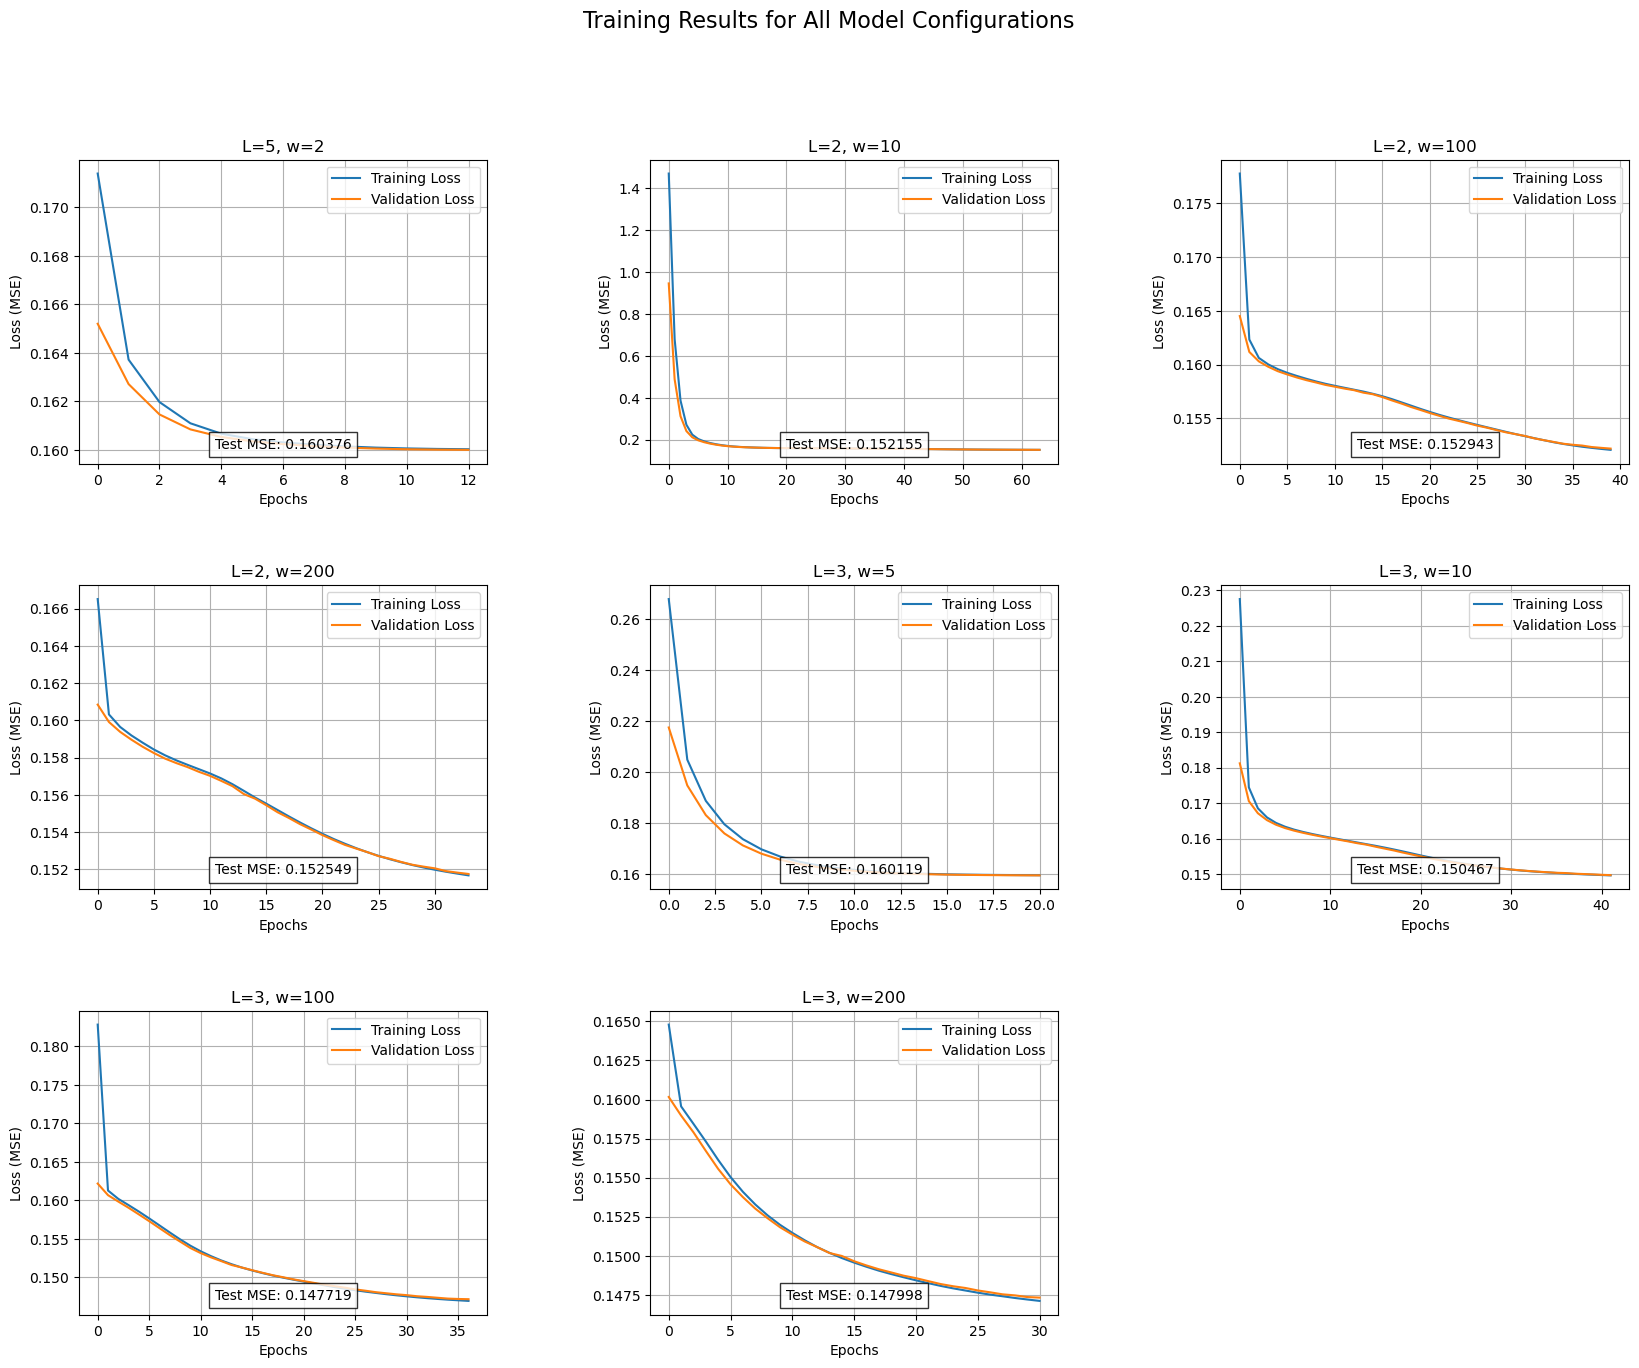


COMPREHENSIVE RESULTS SUMMARY
 Layers (L)  Width (w) Test MSE Final Train Loss Final Val Loss Trainable Params Training Time  Epochs
          3        100 0.147719         0.146936       0.147158           21,001       188.22s      37
          3        200 0.147998         0.147109       0.147321           82,001       324.29s      31
          3         10 0.150467         0.149646       0.149712              301        72.57s      42
          2         10 0.152155         0.151453       0.151464               91        70.44s      64
          2        200 0.152549         0.151684       0.151760            1,801       145.96s      34
          2        100 0.152943         0.152065       0.152182              901        92.31s      40
          3          5 0.160119         0.159449       0.159387              101        30.76s      21
          5          2 0.160376         0.160035       0.160009               49        21.91s      13


In [28]:
# Main execution

# Load and preprocess data
print("Loading data...")
X_train, y_train, X_test, y_test = load_data(
    'xtrain-2.csv', 'ytrain-2.csv',
    'xtest-2.csv', 'ytest-2.csv'
)
print(f"Data loaded successfully. Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Define the configurations to test
configurations = [
    (5, 2),    # First configuration from the task
    (2, 10),   # Additional configurations
    (2, 100),
    (2, 200),
    (3, 5),
    (3, 10),
    (3, 100),
    (3, 200)
]

# Initialize results list and histories dictionary
results_list = []
all_histories = {}

# Run experiments for each configuration
for L, w in configurations:
    print(f"\n{'='*50}")
    print(f"Training model with L={L}, w={w}")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    # Build and train model
    model, history, test_mse = train_and_evaluate(L, w, X_train, y_train, X_test, y_test)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Count trainable parameters
    trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    
    # Store history for later grid plotting
    config_key = f"L={L}, w={w}"
    all_histories[config_key] = history.history
    
    # Store results
    results_list.append({
        'L': L,
        'w': w,
        'test_mse': test_mse,
        'training_time': training_time,
        'trainable_params': trainable_params,
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1],
        'epochs': len(history.history['loss'])
    })
    
    print(f"\nTest MSE for L={L}, w={w}: {test_mse:.6f}")
    print(f"Training completed in {training_time:.2f} seconds")
    print(f"Model has {trainable_params:,} trainable parameters")

# Create a grid of subplots for all configurations
num_configs = len(configurations)
grid_size = math.ceil(math.sqrt(num_configs))  # Calculate grid dimensions

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (config_key, history) in enumerate(all_histories.items()):
    ax = plt.subplot(grid_size, grid_size, i+1)
    
    # Plot training and validation loss
    ax.plot(history['loss'], label='Training Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    
    # Add title and labels
    ax.set_title(config_key)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    ax.grid(True)
    
    # Add final test MSE to the plot
    final_mse = next(result['test_mse'] for result in results_list 
                     if f"L={result['L']}, w={result['w']}" == config_key)
    ax.text(0.5, 0.05, f'Test MSE: {final_mse:.6f}', 
           horizontalalignment='center',
           transform=ax.transAxes,
           bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Training Results for All Model Configurations', fontsize=16)
plt.show()  # This will display in VSCode's plot viewer

# Display comprehensive results table
print("\n" + "="*100)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*100)

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Reorder columns for better display
results_df = results_df[['L', 'w', 'test_mse', 'final_train_loss', 'final_val_loss', 
                         'trainable_params', 'training_time', 'epochs']]

# Sort by test MSE
results_df = results_df.sort_values('test_mse')

# Format numeric columns
results_df['trainable_params'] = results_df['trainable_params'].apply(lambda x: f"{int(x):,}")
results_df['training_time'] = results_df['training_time'].apply(lambda x: f"{x:.2f}s")
results_df['test_mse'] = results_df['test_mse'].apply(lambda x: f"{x:.6f}")
results_df['final_train_loss'] = results_df['final_train_loss'].apply(lambda x: f"{x:.6f}")
results_df['final_val_loss'] = results_df['final_val_loss'].apply(lambda x: f"{x:.6f}")

# Rename columns for clarity
results_df.columns = ['Layers (L)', 'Width (w)', 'Test MSE', 'Final Train Loss', 'Final Val Loss',
                       'Trainable Params', 'Training Time', 'Epochs']

# Print results with improved formatting
print(results_df.to_string(index=False))